## Implementation of Salisman's Don't Overfit submission

From [Kaggle](http://www.kaggle.com/c/overfitting)
>In order to achieve this we have created a simulated data set with 200 variables and 20,000 cases. An ‘equation’ based on this data was created in order to generate a Target to be predicted. Given the all 20,000 cases, the problem is very easy to solve – but you only get given the Target value of 250 cases – the task is to build a model that gives the best predictions on the remaining 19,750 cases.

In [30]:
import gzip
import requests
import zipfile

url = "https://dl.dropbox.com/s/lnly9gw8pb1xhir/overfitting.zip"


results = requests.get(url)

In [31]:
import StringIO
z = zipfile.ZipFile(StringIO.StringIO(results.content))
# z.extractall()

In [32]:
z.extractall()

In [38]:
z.namelist()

['overfitting.csv']

In [69]:
d = z.open('overfitting.csv')
d.readline()

'case_id,train,Target_Practice,Target_Leaderboard,Target_Evaluate,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,va

In [70]:
import numpy as np

In [63]:
M = np.fromstring(d.read(), sep=",")

In [71]:
len(d.read())

23919756

In [75]:
np.fromstring?

In [4]:
data = np.loadtxt("overfitting.csv", delimiter=",", skiprows=1)

In [5]:
print """
There are also 5 other fields,

case_id - 1 to 20,000, a unique identifier for each row

train - 1/0, this is a flag for the first 250 rows which are the training dataset

Target_Practice - we have provided all 20,000 Targets for this model, so you can develop your method completely off line.

Target_Leaderboard - only 250 Targets are provided. You submit your predictions for the remaining 19,750 to the Kaggle leaderboard. 

Target_Evaluate - again only 250 Targets are provided. Those competitors who beat the 'benchmark' on the Leaderboard will be asked to make one further submission for the Evaluation model.

"""

data.shape


There are also 5 other fields,

case_id - 1 to 20,000, a unique identifier for each row

train - 1/0, this is a flag for the first 250 rows which are the training dataset

Target_Practice - we have provided all 20,000 Targets for this model, so you can develop your method completely off line.

Target_Leaderboard - only 250 Targets are provided. You submit your predictions for the remaining 19,750 to the Kaggle leaderboard. 

Target_Evaluate - again only 250 Targets are provided. Those competitors who beat the 'benchmark' on the Leaderboard will be asked to make one further submission for the Evaluation model.




(20000L, 205L)

In [6]:
ix_training = data[:, 1] == 1
ix_testing = data[:, 1] == 0

training_data = data[ix_training, 5:]
testing_data = data[ix_testing, 5:]

training_labels = data[ix_training, 2]
testing_labels = data[ix_testing, 2]

print "training:", training_data.shape, training_labels.shape
print "testing: ", testing_data.shape, testing_labels.shape

training: (250L, 200L) (250L,)
testing:  (19750L, 200L) (19750L,)


## Develop Tim's model

He mentions that the X variables are from a Uniform distribution. Let's investigate this:

In [7]:
figsize(12, 4)

50000


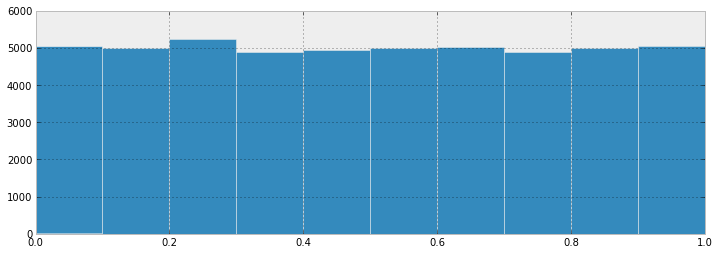

In [8]:
hist(training_data.flatten())
print training_data.shape[0] * training_data.shape[1]

looks pretty right

In [127]:
import pymc as pm

to_include = pm.Bernoulli("to_include", 0.5, size=200)

In [128]:
coef = pm.Uniform("coefs", 0, 1, size=200)

In [129]:
@pm.deterministic
def Z(coef=coef, to_include=to_include, data=training_data):
    ym = np.dot(to_include * training_data, coef)
    return ym - ym.mean()

In [130]:
@pm.deterministic
def T(z=Z):
    return 0.45 * (np.sign(z) + 1.1)

In [132]:
obs = pm.Bernoulli("obs", T, value=training_labels, observed=True)

model = pm.Model([to_include, coef, Z, T, obs])
map_ = pm.MAP(model)
map_.fit()

In [133]:
mcmc = pm.MCMC(model)

In [176]:
mcmc.sample(100000, 90000, 1)

[****************100%******************]  100000 of 100000 complete


In [177]:
(np.round(T.value) == training_labels).mean()

0.73999999999999999

In [178]:
t_trace = mcmc.trace("T")[:]
(np.round(t_trace[-500:-400, :]).mean(axis=0) == training_labels).mean()

0.72399999999999998

In [179]:
t_mean = np.round(t_trace).mean(axis=1)

<matplotlib.colorbar.Colorbar instance at 0x0000000013270208>

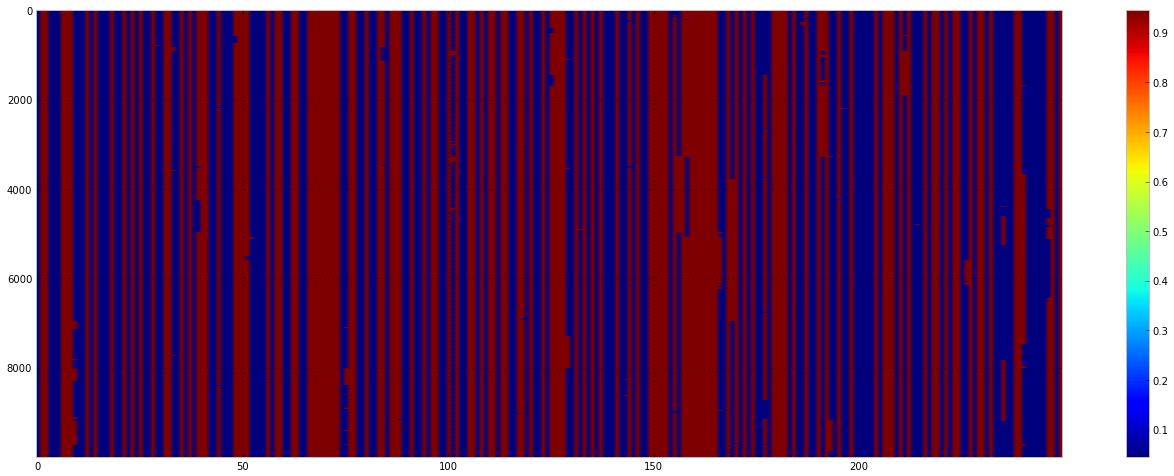

In [180]:
imshow(t_trace[-10000:, :], aspect="auto")
colorbar()

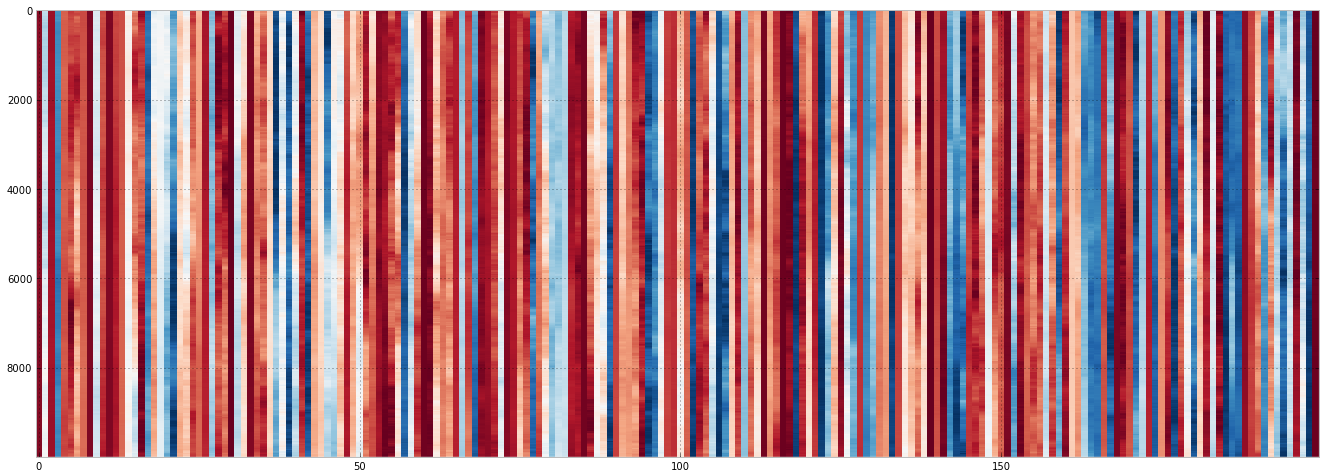

In [181]:
figsize(23, 8)
coef_trace = mcmc.trace("coefs")[:]
imshow(coef_trace[-10000:, :], aspect="auto", cmap=pyplot.cm.RdBu, interpolation="none")

In [183]:
include_trace = mcmc.trace("to_include")[:]

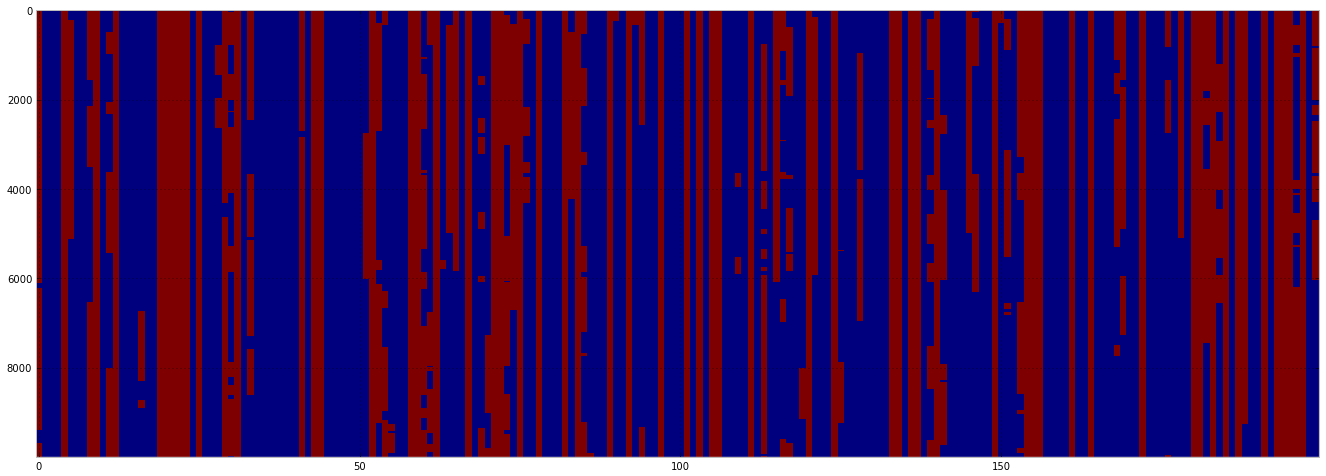

In [184]:
figsize(23, 8)
imshow(include_trace[-10000:, :], aspect="auto", interpolation="none")